In [39]:
import pandas as pd
import os
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch, Pitch
from highlight_text import ax_text, fig_text
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from joblib import Parallel, delayed
from tqdm import tqdm

In [40]:
import pandas as pd
folder = 'Data'
archivo = 'WhoScoredTeamPerMatchSpatial1x1TimeDiv15.csv'

path = os.path.join(folder, archivo)

m1 = pd.read_csv(path)

In [41]:
m1.tail()

,Unnamed: 0,Team,Date,Goals,game_id,Pass_Successful_bin_0_time_0-15,Pass_Unsuccessful_bin_0_time_0-15,Pass_Successful_bin_0_time_15-30,Pass_Unsuccessful_bin_0_time_15-30,Pass_Successful_bin_0_time_30-45,...,Error_Successful_bin_0_time_15-30,Error_Unsuccessful_bin_0_time_15-30,Error_Successful_bin_0_time_30-45,Error_Unsuccessful_bin_0_time_30-45,Error_Successful_bin_0_time_45-60,Error_Unsuccessful_bin_0_time_45-60,Error_Successful_bin_0_time_60-75,Error_Unsuccessful_bin_0_time_60-75,Error_Successful_bin_0_time_75-90,Error_Unsuccessful_bin_0_time_75-90
45931,0,Monaco,2024-02-25,2,1741135,50.0,19.0,34.0,13.0,47.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45932,0,Le Havre,2024-02-25,1,1741137,28.0,15.0,68.0,9.0,97.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45933,0,Reims,2024-02-25,2,1741137,100.0,15.0,57.0,13.0,89.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45934,0,Rennes,2024-02-25,1,1741159,65.0,18.0,44.0,17.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45935,0,PSG,2024-02-25,1,1741159,144.0,19.0,126.0,18.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
columnas = ["game_id", "Date", "Team1", "Team2", "Goals1", "Goals2"]
new_stats = ["wins",
"ties",
"losses",
"total_goals",
"total_goals_conceded",
"points",
"streak",
"wins_in_last_5_matches",
"ties_in_last_5_matches",
"losses_in_last_5_matches"]

stats = m1.columns[6:] # Columnas de estadísticas

for stat in new_stats:
    columnas.append(f"{stat}_1")
    columnas.append(f"{stat}_2")

for stat in stats:
    columnas.append(f"{stat}_1")
    columnas.append(f"{stat}_2")


Creación de tabla con información

In [43]:
tabla = {}
equipos = m1["Team"].unique()

datos = new_stats + list(stats)
for equipo in equipos:

    tabla[equipo] = dict.fromkeys(datos, 0)
    tabla[equipo]["last_5_matches"] = list()
    tabla[equipo]["partidos"] = 0
    tabla[equipo]["id_hace_15"] = 0

In [44]:
tabla["Lorient"].keys()

dict_keys(['wins', 'ties', 'losses', 'total_goals', 'total_goals_conceded', 'points', 'streak', 'wins_in_last_5_matches', 'ties_in_last_5_matches', 'losses_in_last_5_matches', 'Pass_Unsuccessful_bin_0_time_0-15', 'Pass_Successful_bin_0_time_15-30', 'Pass_Unsuccessful_bin_0_time_15-30', 'Pass_Successful_bin_0_time_30-45', 'Pass_Unsuccessful_bin_0_time_30-45', 'Pass_Successful_bin_0_time_45-60', 'Pass_Unsuccessful_bin_0_time_45-60', 'Pass_Successful_bin_0_time_60-75', 'Pass_Unsuccessful_bin_0_time_60-75', 'Pass_Successful_bin_0_time_75-90', 'Pass_Unsuccessful_bin_0_time_75-90', 'TakeOn_Successful_bin_0_time_0-15', 'TakeOn_Unsuccessful_bin_0_time_0-15', 'TakeOn_Successful_bin_0_time_15-30', 'TakeOn_Unsuccessful_bin_0_time_15-30', 'TakeOn_Successful_bin_0_time_30-45', 'TakeOn_Unsuccessful_bin_0_time_30-45', 'TakeOn_Successful_bin_0_time_45-60', 'TakeOn_Unsuccessful_bin_0_time_45-60', 'TakeOn_Successful_bin_0_time_60-75', 'TakeOn_Unsuccessful_bin_0_time_60-75', 'TakeOn_Successful_bin_0_time

In [45]:
matches_columns = columnas
matches = pd.DataFrame(columns=matches_columns)
matches

,game_id,Date,Team1,Team2,Goals1,Goals2,wins_1,wins_2,ties_1,ties_2,...,Error_Unsuccessful_bin_0_time_45-60_1,Error_Unsuccessful_bin_0_time_45-60_2,Error_Successful_bin_0_time_60-75_1,Error_Successful_bin_0_time_60-75_2,Error_Unsuccessful_bin_0_time_60-75_1,Error_Unsuccessful_bin_0_time_60-75_2,Error_Successful_bin_0_time_75-90_1,Error_Successful_bin_0_time_75-90_2,Error_Unsuccessful_bin_0_time_75-90_1,Error_Unsuccessful_bin_0_time_75-90_2


In [46]:
m1 = m1[m1["Date"] > "2022-08-01"]

In [48]:

contador = 0
for game_id in tqdm(m1['game_id'].unique(), desc="Processing games"):
    fila = []
    game = m1[m1['game_id'] == game_id]
    fila.append(game_id)
    fila.append(game['Date'].values[0])
    fila.append(game['Team'].values[0])
    fila.append(game['Team'].values[1])
    fila.append(game['Goals'].values[0])
    fila.append(game['Goals'].values[1])

    team_1 = game['Team'].values[0]
    team_2 = game['Team'].values[1]

    for stat in new_stats:
        fila.append(tabla[team_1][stat])
        fila.append(tabla[team_2][stat])

    for stat in stats:
        fila.append(tabla[team_1][stat])
        fila.append(tabla[team_2][stat])

    matches.loc[len(matches)] = fila

    "Relleno de stats"

    for stat in stats:
        if tabla[team_1]["partidos"] < 15:
            tabla[team_1][stat] += game[stat].values[0]
        if tabla[team_2]["partidos"] < 15:
            tabla[team_2][stat] += game[stat].values[1]
        if tabla[team_1]["partidos"] >= 15:
            tabla[team_1][stat] += game[stat].values[0] - m1[m1["game_id"]==tabla[team_1]["id_hace_15"]][stat].values[0]
            if tabla[team_1][stat] < 0:
                tabla[team_1][stat] = 0
        if tabla[team_2]["partidos"] >= 15:
            tabla[team_2][stat] += game[stat].values[1] - m1[m1["game_id"]==tabla[team_2]["id_hace_15"]][stat].values[0]
            if tabla[team_2][stat] < 0:
                tabla[team_2][stat] = 0

    tabla[team_1]["partidos"] += 1
    tabla[team_2]["partidos"] += 1

    if tabla[team_1]["partidos"] >= 15:
        tabla[team_1]["id_hace_15"] = game_id
    if tabla[team_2]["partidos"] >= 15:
        tabla[team_2]["id_hace_15"] = game_id

    

    # Rellenar stats acumuladas

    empate = False

    if game['Goals'].values[0] > game['Goals'].values[1]:

        tabla[team_1]["wins"] += 1
        tabla[team_2]["losses"] += 1

        tabla[team_1]["total_goals"] += game['Goals'].values[0]
        tabla[team_2]["total_goals"] += game['Goals'].values[1]

        tabla[team_1]["total_goals_conceded"] += game['Goals'].values[1]
        tabla[team_2]["total_goals_conceded"] += game['Goals'].values[0]

        tabla[team_1]["points"] += 3

        tabla[team_1]["streak"] += 1
        tabla[team_2]["streak"] = 0

        if len(tabla[team_1]["last_5_matches"]) == 5:
            tabla[team_1]["last_5_matches"].pop(0)
        if len(tabla[team_2]["last_5_matches"]) == 5:
            tabla[team_2]["last_5_matches"].pop(0)

        tabla[team_1]["last_5_matches"].append("W")
        tabla[team_2]["last_5_matches"].append("L")

    elif game['Goals'].values[0] < game['Goals'].values[1]:

        tabla[team_2]["wins"] += 1
        tabla[team_1]["losses"] += 1

        tabla[team_1]["total_goals"] += game['Goals'].values[0]
        tabla[team_2]["total_goals"] += game['Goals'].values[1]

        tabla[team_1]["total_goals_conceded"] += game['Goals'].values[1]
        tabla[team_2]["total_goals_conceded"] += game['Goals'].values[0]

        tabla[team_2]["points"] += 3

        tabla[team_2]["streak"] += 1
        tabla[team_1]["streak"] = 0

        if len(tabla[team_1]["last_5_matches"]) == 5:
            tabla[team_1]["last_5_matches"].pop(0)
        if len(tabla[team_2]["last_5_matches"]) == 5:
            tabla[team_2]["last_5_matches"].pop(0)

        tabla[team_1]["last_5_matches"].append("L")
        tabla[team_2]["last_5_matches"].append("W")

    else:

        tabla[team_1]["ties"] += 1
        tabla[team_2]["ties"] += 1

        tabla[team_1]["total_goals"] += game['Goals'].values[0]
        tabla[team_2]["total_goals"] += game['Goals'].values[1]

        tabla[team_1]["total_goals_conceded"] += game['Goals'].values[1]
        tabla[team_2]["total_goals_conceded"] += game['Goals'].values[0]

        tabla[team_1]["points"] += 1
        tabla[team_2]["points"] += 1

        tabla[team_1]["streak"] += 1
        tabla[team_2]["streak"] += 1

        if len(tabla[team_1]["last_5_matches"]) == 5:
            tabla[team_1]["last_5_matches"].pop(0)
        if len(tabla[team_2]["last_5_matches"]) == 5:
            tabla[team_2]["last_5_matches"].pop(0)

        tabla[team_1]["last_5_matches"].append("T")
        tabla[team_2]["last_5_matches"].append("T")
    
    tabla[team_1]["wins_in_last_5_matches"] = tabla[team_1]["last_5_matches"].count("W")
    tabla[team_1]["ties_in_last_5_matches"] = tabla[team_1]["last_5_matches"].count("T")
    tabla[team_1]["losses_in_last_5_matches"] = tabla[team_1]["last_5_matches"].count("L")

    tabla[team_2]["wins_in_last_5_matches"] = tabla[team_2]["last_5_matches"].count("W")
    tabla[team_2]["ties_in_last_5_matches"] = tabla[team_2]["last_5_matches"].count("T")
    tabla[team_2]["losses_in_last_5_matches"] = tabla[team_2]["last_5_matches"].count("L")


Processing games: 100%|██████████| 2985/2985 [09:52<00:00,  5.04it/s]


In [49]:
matches.tail()


,game_id,Date,Team1,Team2,Goals1,Goals2,wins_1,wins_2,ties_1,ties_2,...,Error_Unsuccessful_bin_0_time_45-60_1,Error_Unsuccessful_bin_0_time_45-60_2,Error_Successful_bin_0_time_60-75_1,Error_Successful_bin_0_time_60-75_2,Error_Unsuccessful_bin_0_time_60-75_1,Error_Unsuccessful_bin_0_time_60-75_2,Error_Successful_bin_0_time_75-90_1,Error_Successful_bin_0_time_75-90_2,Error_Unsuccessful_bin_0_time_75-90_1,Error_Unsuccessful_bin_0_time_75-90_2
4558,1741127,2024-02-25,Lille,Toulouse,1,3,49,32,26,22,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
4559,1741133,2024-02-25,Nice,Clermont Foot,0,0,36,34,33,22,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
4560,1741135,2024-02-25,Lens,Monaco,3,2,53,49,24,17,...,0.0,0.0,2.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0
4561,1741137,2024-02-25,Le Havre,Reims,1,2,5,31,9,33,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
4562,1741159,2024-02-25,Rennes,PSG,1,1,48,64,18,15,...,0.0,0.0,6.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0


# ML

In [50]:
results = []

for index in matches.index:

    match = matches.loc[index]
    if match["Goals1"] > match["Goals2"]:
        results.append(1)
    elif match["Goals1"] < match["Goals2"]:
        results.append(2)
    else:
        results.append(0)

matches["result"] = results

In [51]:
for i in range(0,3):
    cantidad = matches[matches["result"]==i].shape[0]
    print(f"Resultado {i}, hay: {cantidad} partidos, {cantidad*100/len(matches)}%")

Resultado 0, hay: 1143 partidos, 25.04930966469428%
Resultado 1, hay: 1892 partidos, 41.463949156256845%
Resultado 2, hay: 1528 partidos, 33.48674117904887%


In [52]:
result = matches["result"]
matches = matches.drop(columns = ["game_id", "Date", "Team1", "Team2", "Goals1", "Goals2", "result"])

In [53]:
matches

,wins_1,wins_2,ties_1,ties_2,losses_1,losses_2,total_goals_1,total_goals_2,total_goals_conceded_1,total_goals_conceded_2,...,Error_Unsuccessful_bin_0_time_45-60_1,Error_Unsuccessful_bin_0_time_45-60_2,Error_Successful_bin_0_time_60-75_1,Error_Successful_bin_0_time_60-75_2,Error_Unsuccessful_bin_0_time_60-75_1,Error_Unsuccessful_bin_0_time_60-75_2,Error_Successful_bin_0_time_75-90_1,Error_Successful_bin_0_time_75-90_2,Error_Unsuccessful_bin_0_time_75-90_1,Error_Unsuccessful_bin_0_time_75-90_2
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4558,49,32,26,22,18,39,163,125,95,138,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
4559,36,34,33,22,24,37,108,96,85,129,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
4560,53,49,24,17,16,27,149,182,77,135,...,0.0,0.0,2.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0
4561,5,31,9,33,8,29,24,115,27,108,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0


In [54]:
X = matches.to_numpy()
scaler = preprocessing.StandardScaler()
X_escalados = scaler.fit_transform(X)
y = result

In [55]:
y.unique()

array([0, 1, 2], dtype=int64)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_escalados, y, test_size=0.3, random_state = 1, stratify=y)

# Modelo 1: Regresión Logística

In [57]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter = 1000)
logistic_reg.fit(X_train, y_train)

predicted_logistic_reg = logistic_reg.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_logistic_reg))

Clasification report
              precision    recall  f1-score   support

           0       0.37      0.32      0.34       343
           1       0.56      0.60      0.58       568
           2       0.49      0.50      0.49       458

    accuracy                           0.49      1369
   macro avg       0.47      0.47      0.47      1369
weighted avg       0.49      0.49      0.49      1369



In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


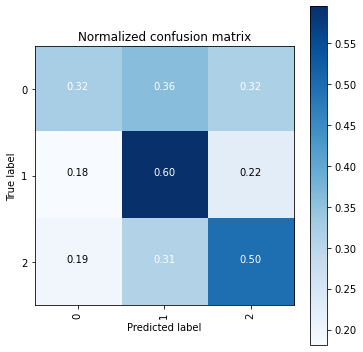

In [59]:
cnf_matrix = confusion_matrix(y_test, predicted_logistic_reg)
np.set_printoptions(precision=2)
classes = np.unique(y)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## SVM

In [60]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svm = SVC(kernel = kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        f"For kernel = {kernel}, the accuracy is: {acc}"
    )


For kernel = linear, the accuracy is: 0.46384222059897734
For kernel = poly, the accuracy is: 0.4594594594594595
For kernel = rbf, the accuracy is: 0.5171658144631117
For kernel = sigmoid, the accuracy is: 0.43754565376187


In [61]:
from sklearn.svm import SVC

svm = SVC(kernel = "rbf")

svm.fit(X_train, y_train)

predicted_svm = svm.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_svm))

Clasification report
              precision    recall  f1-score   support

           0       0.45      0.13      0.20       343
           1       0.55      0.75      0.63       568
           2       0.49      0.52      0.50       458

    accuracy                           0.52      1369
   macro avg       0.49      0.47      0.45      1369
weighted avg       0.50      0.52      0.48      1369



Normalized confusion matrix


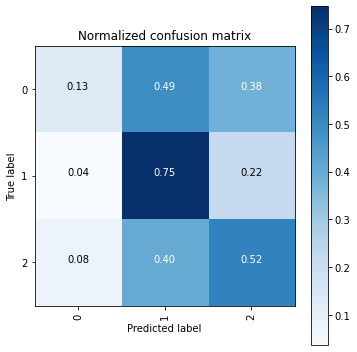

In [62]:
cnf_matrix = confusion_matrix(y_test, predicted_svm)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

range_T = [50, 100, 200, 500, 1000]


for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=50, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 50 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=20, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 20 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=10, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 10 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = RandomForestClassifier(min_samples_split=5, n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For min_samples_split = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


For min_samples_split = 50 and t = 50 The accuracy is : 0.5025566106647188
For min_samples_split = 50 and t = 100 The accuracy is : 0.5047479912344777
For min_samples_split = 50 and t = 200 The accuracy is : 0.4996347699050402
For min_samples_split = 50 and t = 500 The accuracy is : 0.49233016800584367
For min_samples_split = 50 and t = 1000 The accuracy is : 0.4996347699050402
For min_samples_split = 20 and t = 50 The accuracy is : 0.493791088385683
For min_samples_split = 20 and t = 100 The accuracy is : 0.48867786705624544
For min_samples_split = 20 and t = 200 The accuracy is : 0.4974433893352812
For min_samples_split = 20 and t = 500 The accuracy is : 0.48940832724616506
For min_samples_split = 20 and t = 1000 The accuracy is : 0.49233016800584367
For min_samples_split = 10 and t = 50 The accuracy is : 0.48794740686632576
For min_samples_split = 10 and t = 100 The accuracy is : 0.4959824689554419
For min_samples_split = 10 and t = 200 The accuracy is : 0.504017531044558
For min_sa

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_split=50, n_estimators=100, random_state=0)

rf.fit(X_train, y_train)

predicted_rf = rf.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_rf))

Clasification report
              precision    recall  f1-score   support

           0       0.42      0.05      0.08       343
           1       0.52      0.76      0.62       568
           2       0.48      0.53      0.50       458

    accuracy                           0.50      1369
   macro avg       0.47      0.45      0.40      1369
weighted avg       0.48      0.50      0.45      1369



Normalized confusion matrix


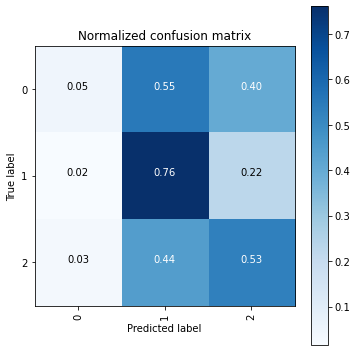

In [65]:
cnf_matrix = confusion_matrix(y_test, predicted_rf)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## AdaBoost

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

range_T = [50, 100, 200, 500, 1000]




for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 2 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 3 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 4 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 6 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 7 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=t_, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 8 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


For max_depth = 2 and t = 50 The accuracy is : 0.46092037983929873
For max_depth = 2 and t = 100 The accuracy is : 0.45069393718042366
For max_depth = 2 and t = 200 The accuracy is : 0.4579985390796202
For max_depth = 2 and t = 500 The accuracy is : 0.4733382030679328
For max_depth = 2 and t = 1000 The accuracy is : 0.4616508400292184
For max_depth = 3 and t = 50 The accuracy is : 0.44850255661066474
For max_depth = 3 and t = 100 The accuracy is : 0.4360847333820307
For max_depth = 3 and t = 200 The accuracy is : 0.4419284149013879
For max_depth = 3 and t = 500 The accuracy is : 0.4565376186997809
For max_depth = 3 and t = 1000 The accuracy is : 0.464572680788897
For max_depth = 4 and t = 50 The accuracy is : 0.4704163623082542
For max_depth = 4 and t = 100 The accuracy is : 0.44923301680058436
For max_depth = 4 and t = 200 The accuracy is : 0.46968590211833455
For max_depth = 4 and t = 500 The accuracy is : 0.47406866325785246
For max_depth = 4 and t = 1000 The accuracy is : 0.4777209

In [67]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7), n_estimators=1000, random_state=0)

ada.fit(X_train, y_train)

predicted_ada = ada.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_ada))

Clasification report
              precision    recall  f1-score   support

           0       0.34      0.19      0.24       343
           1       0.54      0.69      0.61       568
           2       0.48      0.47      0.47       458

    accuracy                           0.49      1369
   macro avg       0.45      0.45      0.44      1369
weighted avg       0.47      0.49      0.47      1369



Normalized confusion matrix


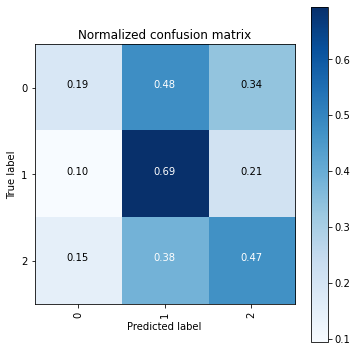

In [68]:
cnf_matrix = confusion_matrix(y_test, predicted_ada)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## GradientBoosting

In [69]:
from sklearn.ensemble import GradientBoostingClassifier

range_T = [50, 100, 200, 500, 1000]




for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 2 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =3, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 3 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =4, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 4 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =5, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =6, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 6 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =7, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 7 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = GradientBoostingClassifier(n_estimators=t_, max_depth =8, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 8 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


For max_depth = 2 and t = 50 The accuracy is : 0.493791088385683
For max_depth = 2 and t = 100 The accuracy is : 0.5076698319941563
For max_depth = 2 and t = 200 The accuracy is : 0.5091307523739956
For max_depth = 2 and t = 500 The accuracy is : 0.5010956902848794
For max_depth = 2 and t = 1000 The accuracy is : 0.48721694667640614
For max_depth = 3 and t = 50 The accuracy is : 0.5054784514243974
For max_depth = 3 and t = 100 The accuracy is : 0.5113221329437546
For max_depth = 3 and t = 200 The accuracy is : 0.5098612125639153
For max_depth = 3 and t = 500 The accuracy is : 0.5018261504747992
For max_depth = 3 and t = 1000 The accuracy is : 0.49452154857560265
For max_depth = 4 and t = 50 The accuracy is : 0.4959824689554419
For max_depth = 4 and t = 100 The accuracy is : 0.4989043097151205
For max_depth = 4 and t = 200 The accuracy is : 0.49233016800584367
For max_depth = 4 and t = 500 The accuracy is : 0.4850255661066472
For max_depth = 4 and t = 1000 The accuracy is : 0.4937910883

In [71]:
gb = GradientBoostingClassifier(n_estimators=200, max_depth =8, random_state=0)

gb.fit(X_train, y_train)

predicted_gb = gb.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_gb))

Clasification report
              precision    recall  f1-score   support

           0       0.37      0.22      0.28       343
           1       0.58      0.68      0.62       568
           2       0.51      0.54      0.53       458

    accuracy                           0.52      1369
   macro avg       0.49      0.48      0.48      1369
weighted avg       0.50      0.52      0.50      1369



Normalized confusion matrix


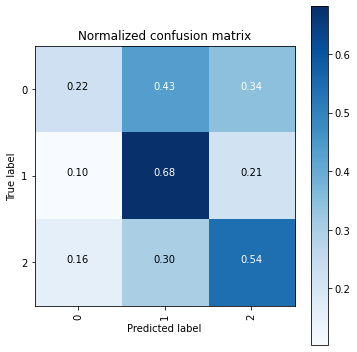

In [72]:
cnf_matrix = confusion_matrix(y_test, predicted_gb)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## XGboost

In [73]:
from xgboost import XGBClassifier


range_T = [50, 100, 200, 500, 1000]




for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 2 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =3, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 3 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =4, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 4 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =5, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 5 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =6, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 6 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =7, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 7 and t =",
        t_,
        "The accuracy is :",
        acc,
    )


for t_ in range_T:
    clf = XGBClassifier(n_estimators=t_, max_depth =8, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(
        "For max_depth = 8 and t =",
        t_,
        "The accuracy is :",
        acc,
    )

For max_depth = 2 and t = 50 The accuracy is : 0.506208911614317
For max_depth = 2 and t = 100 The accuracy is : 0.506208911614317
For max_depth = 2 and t = 200 The accuracy is : 0.4850255661066472
For max_depth = 2 and t = 500 The accuracy is : 0.48429510591672753
For max_depth = 2 and t = 1000 The accuracy is : 0.4813732651570489
For max_depth = 3 and t = 50 The accuracy is : 0.4989043097151205
For max_depth = 3 and t = 100 The accuracy is : 0.49233016800584367
For max_depth = 3 and t = 200 The accuracy is : 0.48794740686632576
For max_depth = 3 and t = 500 The accuracy is : 0.504017531044558
For max_depth = 3 and t = 1000 The accuracy is : 0.5098612125639153
For max_depth = 4 and t = 50 The accuracy is : 0.4952520087655223
For max_depth = 4 and t = 100 The accuracy is : 0.4967129291453616
For max_depth = 4 and t = 200 The accuracy is : 0.4981738495252009
For max_depth = 4 and t = 500 The accuracy is : 0.5113221329437546
For max_depth = 4 and t = 1000 The accuracy is : 0.520087655222

In [74]:
xgb = XGBClassifier(max_depth = 6, n_estimators = 100)

xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)
print("Clasification report")
print(classification_report(y_test, predicted_xgb))


Clasification report
              precision    recall  f1-score   support

           0       0.43      0.24      0.31       343
           1       0.59      0.68      0.63       568
           2       0.49      0.55      0.52       458

    accuracy                           0.53      1369
   macro avg       0.50      0.49      0.48      1369
weighted avg       0.51      0.53      0.51      1369



Normalized confusion matrix


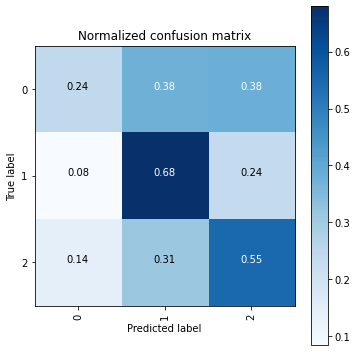

In [75]:
cnf_matrix = confusion_matrix(y_test, predicted_xgb)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

## MLP

In [82]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Embedding, Concatenate
from tensorflow.keras.models import Model

mlp = Sequential([
    Input(shape = X_train[0].shape[0]),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(32, activation= "relu"),
    Dense(3, activation = "softmax")
])

mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               82304     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 92739 (362.26 KB)
Trainable params: 92739 (362.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) # Conjunto de validación = 0.8*0.25 = 0.2, este valor es estándar para validación

y_train2 = keras.utils.to_categorical(y_train2, 3)
y_val = keras.utils.to_categorical(y_val, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [84]:
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Ajusta la función de pérdida según el tipo de problema categorical es para multi clases
mlp.fit(X_train2, y_train2, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
75/75 [==============================] - 1s 4ms/step - loss: 1.0656 - accuracy: 0.4543 - val_loss: 1.0386 - val_accuracy: 0.4931
Epoch 2/20
75/75 [==============================] - 0s 2ms/step - loss: 0.9210 - accuracy: 0.5745 - val_loss: 1.0618 - val_accuracy: 0.4819
Epoch 3/20
75/75 [==============================] - 0s 2ms/step - loss: 0.8176 - accuracy: 0.6334 - val_loss: 1.0895 - val_accuracy: 0.4631
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.7052 - val_loss: 1.1439 - val_accuracy: 0.4793
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 0.5832 - accuracy: 0.7712 - val_loss: 1.2263 - val_accuracy: 0.4768
Epoch 6/20
75/75 [==============================] - 0s 2ms/step - loss: 0.4764 - accuracy: 0.8129 - val_loss: 1.3357 - val_accuracy: 0.4768
Epoch 7/20
75/75 [==============================] - 0s 2ms/step - loss: 0.3839 - accuracy: 0.8551 - val_loss: 1.3750 - val_accuracy: 0.5056
Epoch 8/20
75/75 [==

In [85]:
predicted_mlp = mlp.predict(X_test)
predicted_mlp = [np.argmax(x) for x in predicted_mlp]
y_test = [np.argmax(x) for x in y_test]

43/43 [==============================] - 0s 929us/step


In [86]:
print("Clasification report")
print(classification_report(y_test, predicted_mlp))

Clasification report
              precision    recall  f1-score   support

           0       0.43      0.27      0.33       343
           1       0.55      0.63      0.59       568
           2       0.47      0.53      0.50       458

    accuracy                           0.50      1369
   macro avg       0.49      0.47      0.47      1369
weighted avg       0.50      0.50      0.49      1369



Normalized confusion matrix


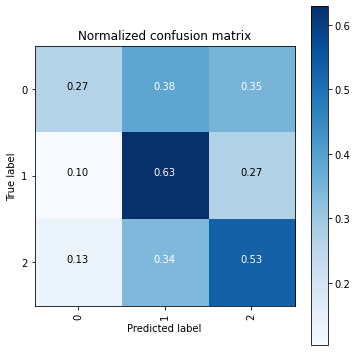

In [87]:
cnf_matrix = confusion_matrix(y_test, predicted_mlp)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()